In [1]:
import os
import sys
if True:
    sys.path.insert(0, '../')
import torch
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
import pandas as pd
from utils.store_data import ReadData
import numpy as np
import torch
from utils.arguments import Arguments
from tqdm import tqdm
from linear_probe import get_linear_acc
import random
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve

In [2]:
data_reader=ReadData('/root/autodl-tmp/hallscope/pope/adversarial/train')
data=data_reader.read_all()
random.shuffle(data)

In [3]:
df=pd.DataFrame(data)

In [4]:
df.head()

,img_path,question,label,question_id,most_likely,responses
0,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there an orange in the image?\nAnswer the ...,[tensor(1)],[tensor(3869)],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
1,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a chair in the image?\nAnswer the qu...,[tensor(0)],[tensor(3250)],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
2,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a car in the image?\nAnswer the ques...,[tensor(1)],[tensor(1093)],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
3,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a person in the image?\nAnswer the q...,[tensor(0)],[tensor(734)],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
4,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a bottle in the image?\nAnswer the q...,[tensor(0)],[tensor(4364)],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None


In [5]:
embeddings=df['most_likely'].apply(lambda x: x['embedding']).to_list()

In [6]:
embeddings=np.concatenate(embeddings,axis=0)

In [7]:
embeddings.shape

(5000, 29, 3584)

In [8]:
gt_label=df['label'].to_list()
gt_label=np.concatenate(gt_label,axis=0)

In [9]:
gt_label.shape

(5000,)

In [10]:
responses=df['most_likely'].apply(lambda x: x['response']).to_list()
resps=[]
for x in responses:
    resps+=x

In [11]:
is_correct=[]
for i,x in enumerate(resps):
    if x.lower()=='no' and gt_label[i]==0:
        is_correct.append(1)
    elif x.lower()=='yes' and gt_label[i]==1:
        is_correct.append(1)
    else:
        is_correct.append(0)
is_correct=np.array(is_correct)

In [12]:
is_correct.shape

(5000,)

In [13]:
print(f'There are {len(is_correct)} responses. {sum(is_correct==1)} answer correctly and {sum(is_correct==0)} answer wrongly')

There are 5000 responses. 4324 answer correctly and 676 answer wrongly


In [14]:
length=len(is_correct)
train_rate=0.45

all_indices = np.random.permutation(length)
train_val_idxs = all_indices[:int(
    train_rate * length)]  # trainset and validation index

test_idxs=all_indices[int(
    train_rate * length):]  #test index

validset_len = 1
# exclude validation samples.
train_idxs = train_val_idxs[:len(
    train_val_idxs) - validset_len]  # trainset index
val_idxs = train_val_idxs[len(
    train_val_idxs) - validset_len:]  # validation index
hall_label_test = []
hall_label_wild = []
hall_label_val = []

'''get testset, wildset and valset. The valset is used for determining the hype-parameters'''
hall_label_test = is_correct[test_idxs]
hall_label_wild = is_correct[train_idxs]
hall_label_val = is_correct[val_idxs]

print(f'trainset length:{len(hall_label_wild)}')
print(f'validset length:{len(hall_label_val)}')
print(f'testset length:{len(hall_label_test)}')
print(f'trainset postive: {sum(hall_label_wild==1)} negative: {sum(hall_label_wild==0)}')
print(f'valset postive: {sum(hall_label_val==1)} negative: {sum(hall_label_val==0)}')
print(f'testset postive: {sum(hall_label_test==1)} negative: {sum(hall_label_test==0)}')

trainset length:2249
validset length:1
testset length:2750
trainset postive: 1940 negative: 309
valset postive: 1 negative: 0
testset postive: 2383 negative: 367


In [15]:
all_embeddings = embeddings
all_embeddings.shape

(5000, 29, 3584)

In [16]:
embedding_train = all_embeddings[train_idxs]
embedding_val = all_embeddings[val_idxs]
embedding_test = all_embeddings[test_idxs]

In [17]:
%load_ext autoreload
%autoreload 2
from ml_utils.grid_search import GridSearch
from ml_utils.PCA_discriminator import PCALinear,PCAKernel,KernelPCA
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,f1_score,balanced_accuracy_score
from ml_utils.metrics import auc_pr

Grid Search for Best 'n_components' & 'layer'

In [18]:
best_layer=27
#best_layer=24

View Results on Training set and Test set

In [19]:
M=3584
discriminator=KernelPCA(embedding_train[:,best_layer,:],2,M,method='CoP',gamma=1)
scores=discriminator.get_score(embedding_train[:,best_layer,:])
best_split=discriminator.get_best_split(scores,hall_label_wild)

In [20]:
X_pca=discriminator.transform(embedding_train[:,best_layer,:])

In [21]:
X_pca.shape

(2249, 2)

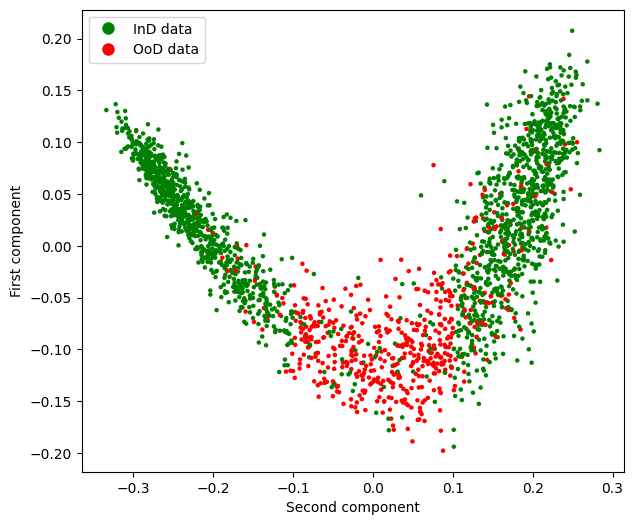

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load sample data
data = X_pca
labels = hall_label_wild

custom_cmap = ListedColormap(['red', 'green'])
unique_labels = np.unique(labels)
label_names = ['OoD data', 'InD data'] 

# Fit and transform the data
tsne_result = X_pca

idx=[]
for i in range(X_pca.shape[0]):
    if X_pca[i,0]<0.1 and X_pca[i,0]>-0.1:
        if X_pca[i,1]<0 and X_pca[i,1]>-0.2:
            idx.append(i)
            
idx=np.array(idx)
np.random.shuffle(idx)
idx=idx[:int(len(idx)*0.6)]
labels[idx]=0


# Plotting the t-SNE result
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=custom_cmap, s=5)


green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='InD data')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='OoD data')
plt.legend(handles=[green_patch, red_patch])

plt.xlabel('Second component')
plt.ylabel('First component')

plt.savefig('direct_vs_linear.pdf',format="pdf",bbox_inches='tight')
plt.show()

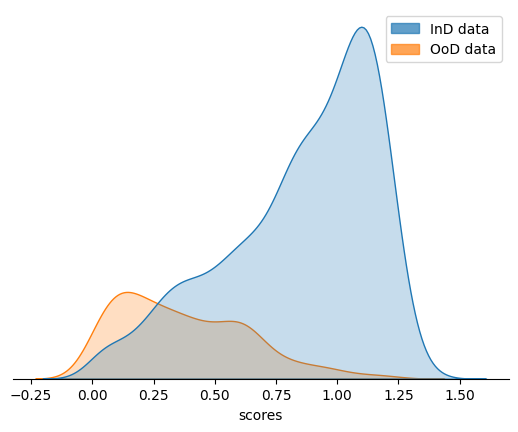

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

data=np.stack((scores,hall_label_wild)).T

df = pd.DataFrame(data, columns=['scores', 'label'])

label_mapping = {0: 'OoD data', 1: 'InD data'}
df['label'] = df['label'].map(label_mapping)

# Create a density plot
sns.kdeplot(data=df, x="scores", hue="label", fill=True)


# Remove the title 'label' from the legend
handles = [
    mpatches.Patch(color=sns.color_palette()[0], label='InD data', alpha=0.7),
    mpatches.Patch(color=sns.color_palette()[1],label='OoD data' , alpha=0.7)
]
plt.legend(handles=handles, title='')
sns.despine(left=True)
#plt.gca().axes.yaxis.set_visible(False)  # Hide y-axis

# Show the plot
plt.show()

In [24]:
M=3584
discriminator=KernelPCA(embedding_train[:,best_layer,:],2,M,method='CoRP',gamma=1)
scores=discriminator.get_score(embedding_train[:,best_layer,:])

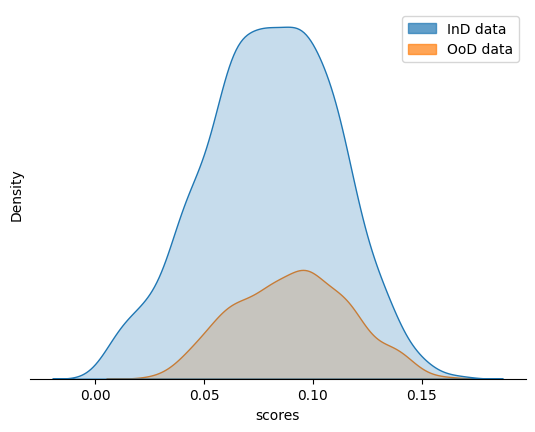

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

data=np.stack((scores,hall_label_wild)).T

df = pd.DataFrame(data, columns=['scores', 'label'])

label_mapping = {0: 'OoD data', 1: 'InD data'}
df['label'] = df['label'].map(label_mapping)

# Create a density plot
sns.kdeplot(data=df, x="scores", hue="label", fill=True)


# Remove the title 'label' from the legend
handles = [
    mpatches.Patch(color=sns.color_palette()[0], label='InD data', alpha=0.7),
    mpatches.Patch(color=sns.color_palette()[1],label='OoD data' , alpha=0.7)
]
plt.legend(handles=handles, title='')
sns.despine(left=True)

plt.ylabel('Density')
#plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)

# Show the plot
plt.show()